# Compare diferent prediction results
## Imports

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from Matrix import convert_matrix
from NMF import generateNMF
from sklearn.model_selection import train_test_split
import psycopg2

import numpy
from psycopg2.extensions import register_adapter, AsIs

# Get the data

In [2]:
table = convert_matrix()
table

(590, 18683)


aaaaac  aaaaad  aaaaae  aaaaaf  aaaaag  aaaaah  aaaaai  \
subject_id isAlive                                                           
20         0             0      18       0       1       0       0       0   
135        1             0      20       0       1       2       0       0   
151        1             2      80       0       0       0       0       0   
177        1             0      11       0       9       1       0       0   
214        1             1      54       0      34       9       0       0   
263        1             0       1       0       0       2       0       0   
279        1             0       5       0       0       0       0       0   
283        1             0       0       0       0       0       0       0   
368        1            54       5       0       3       2       0       0   
377        1            10      84       0      17       7       2       0   
408        1             0     297       0       5       1       0       0   
462        0             0      15       0       4       0       0       0   
618        1             0       4       0       0       0       0       0   
638        1             1      24       0       3       1       2       0   
682        1             6     116       1     382      81      18       0   
736        0             0       0       1       0       0       0       0   
743        1             3       5       0       0       0       0       0   
749        1             1     295       0      32       4       0       0   
793        1             2     625       0      46      14       1       0   
886        1             0     572       0      69      16       1       0   
952        1             1      12       0       1       1       1       0   
974        0             1      20       0       1       0       0       0   
1004       1             0       1       0       0       0       0       0   
1075       1             8     201       0      18       0       1       0   
1144       0            10     134       0      11       3       1       0   
1160       0             0     116       0       2       2       0       0   
1222       0             0      61       0      12       2       1       0   
1226       1             1       2       0       0       0       0       0   
1459       0             0     163       0       5       0       0       0   
1528       1             1     155       0      91      12       3       0   
...                    ...     ...     ...     ...     ...     ...     ...   
23178      1           153      59       0       5       1       0       0   
23193      0             1      15       0       2       0       0       0   
23200      0            14       0       0       0       0       0       0   
23298      0            12      18       3       4       0       2       0   
23336      1             3      29       0       0       0       1       0   
23339      0             0       1       0       0       1       0       0   
23363      1             3      45       0       6       2       1       0   
23384      0             0       0       0       0       0       0       0   
23401      1             0     154       0       1       1       0       0   
23451      1             0       0       0       0       0       0       0   
23468      1            26      75       0       2       0       0       0   
23474      1             2       7       0       5       0       0       0   
23510      1             0       5       0       1       0       0       0   
23944      1            17       0       0       0       0       0       0   
24004      1            29      92       0      21       0       1       0   
24030      0             0       2       0       0       1       0       0   
24076      1             0      51       0       1       0       0       0   
24129      1             0       6       0       0       0       0       0   
24133      0           251       6       0

# Dividir los datos entre datos de entrenamiento y datos de prueba

In [3]:
subjects = table.index.levels[0].tolist()
survived = table.index.labels[1].tolist()
patients = table.values
patients_train, patients_test,subject_train, subject_test,survived_train, survived_test = train_test_split(patients,subjects, 
                                                                               survived,test_size=0.2, random_state=42)

## Obtener los score de SOFA y SAPS

In [4]:
def select_score(subjects, table='saps', dbname="mimic"):
    """Selects the saps of the subjects.
    """
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT a.'''+table+''',a.icustay_id
    FROM '''+table+''' a
    INNER JOIN (select subject_id,max(icustay_id) as icustay_id from '''+table+''' group by subject_id) b
    ON a.subject_id = b.subject_id and a.icustay_id = b.icustay_id
    WHERE a.subject_id in %s '''
    cur.execute(select_stament,(subjects,))
    select = []
    for row in cur:
        select.append((row[0]))
    cur.close()
    conn.close()
    return select

In [5]:
def addapt_numpy_float64(numpy_float64):
  return AsIs(numpy_float64)
register_adapter(numpy.float64, addapt_numpy_float64)
def addapt_numpy_int64(numpy_int64):
  return AsIs(numpy_int64)
register_adapter(numpy.int64, addapt_numpy_int64)

In [6]:
saps = select_score(tuple(subject_test),table='saps')
sofa = select_score(tuple(subject_test),table='sofa')

In [7]:
from math import log
Score = 24
logit = -7.7631+0.0737*Score + 0.9971*log(Score+1)
logit

-2.7847589150239163

In [8]:
from sklearn.metrics import roc_auc_score
roc_auc_saps = roc_auc_score(survived_test, saps)
roc_auc_sofa = roc_auc_score(survived_test, sofa)

## Obtener el modelo de la regresion logistica

In [9]:
model,accuracy_score,roc_auc_logit = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)
regresion = model.predict_proba(patients_test)[:,1]

acurracy is 62.7119%


## Obtener el modelo de NMF

In [10]:
components = [{'n_components':11,'type':'Elbow del error'},
             {'n_components':36,'type':'Mejor Coeficiente de pearson'},
             {'n_components':88,'type':'Maximo AUC'},
             {'n_components':25,'type':'Maximo Exactitud de la regresion logistica'}]
nmfresults = []
for component in components:
    n_components = component['n_components']
    modelnmf, nmf, patients_nmf, acurracy, roc_auc_nmf = generateNMF(patients, survived,
                                                                     n_components=n_components)
    patients_test_nmf = nmf.transform(patients_test)
    score = modelnmf.predict_proba(patients_test_nmf)[:,1]
    nmfresults.append({'name':'NMF '+str(n_components), 'score':score, 'roc_auc':roc_auc_nmf})

acurracy is 77.1186%
acurracy is 72.8814%
acurracy is 76.2712%
acurracy is 81.3559%


## Imprimir los resultados

In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [12]:
def roc_curveplot(name,y_true,y_score,logit_roc_auc):
    fpr, tpr, thresholds = roc_curve(y_true,y_score)
    plt.plot(fpr,tpr,label='ROC '+str(name)+' curve (AUC =%0.3f)' % logit_roc_auc)

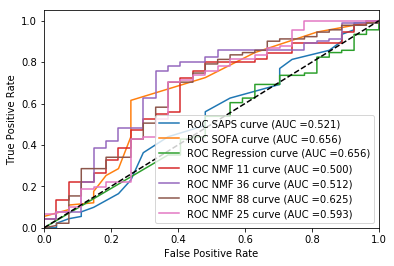

In [13]:
plt.figure()
roc_curveplot('SAPS',survived_test,saps,roc_auc_saps)
roc_curveplot('SOFA',survived_test,sofa,roc_auc_sofa)
roc_curveplot('Regression',survived_test,regresion,roc_auc_sofa)
for nmfresult in nmfresults:
    roc_curveplot(nmfresult['name'],survived_test,nmfresult['score'],nmfresult['roc_auc'])
#for resul in nmfResult : 
#    roc_curveplot('NMF '+str(resul['name']),resul['model'],survived,resul['patients'],resul['roc_auc'])
#roc_curveplot('NMF '+str(bestScore),modelnmf,survived,patientnmf,nmf_roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()